# Project A: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
!pip install keras-flops
from keras_flops import get_flops



import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union

tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.


# Data loading

In [4]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)
print('mnist_train shape:', mnist_train)
print('mnist_test shape:', mnist_test)


Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
mnist_train shape: <BatchDataset element_spec=(TensorSpec(shape=(256, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(256, 10), dtype=tf.float32, name=None))>
mnist_test shape: <BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


# Model creation

In [6]:
##@ test {"output": "ignore"}

# Teacher.
mod1 = tf.keras.Sequential()

# your code start from here for step 2
mod1.add(tf.keras.layers.Conv2D(32, (3,3), strides=1, activation="relu",input_shape=(28, 28,1)))
mod1.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=1))
mod1.add(tf.keras.layers.Conv2D(64, (3,3), strides=1, activation="relu"))
mod1.add(tf.keras.layers.MaxPooling2D((2, 2), strides=2))
mod1.add(tf.keras.layers.Flatten())
mod1.add(tf.keras.layers.Dropout(0.5))
mod1.add(tf.keras.layers.Dense(128, activation="relu"))
mod1.add(tf.keras.layers.Dropout(0.5))
mod1.add(tf.keras.layers.Dense(NUM_CLASSES))


# Dnn student

# your code start from here for step 2
stu_mod = tf.keras.Sequential()
stu_mod.add(tf.keras.layers.Flatten(input_shape=( 28, 28,1)))
stu_mod.add(tf.keras.layers.Dense(748, activation="relu"))
stu_mod.add(tf.keras.layers.Dense(748, activation="relu"))
stu_mod.add(tf.keras.layers.Dense(NUM_CLASSES))

# teacher 2.
model_t = tf.keras.Sequential()

model_t.add(tf.keras.layers.Conv2D(32, (3,3), strides=1, activation="relu",input_shape=(28, 28,1)))
model_t.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=1))
model_t.add(tf.keras.layers.Flatten())
model_t.add(tf.keras.layers.Dropout(0.5))
model_t.add(tf.keras.layers.Dense(256, activation="relu"))
model_t.add(tf.keras.layers.Dense(NUM_CLASSES))


model_t.summary()

mod1.summary()
stu_mod.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 20000)             0         
                                                                 
 dropout_4 (Dropout)         (None, 20000)             0         
                                                                 
 dense_7 (Dense)             (None, 256)               5120256   
                                                                 
 dense_8 (Dense)             (None, 10)                2570      
                                                      

# Teacher loss function

In [ ]:
@tf.function
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = cnn_model(images, training=True)

 
  cross_entropy_loss_value=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=subclass_logits))
  


  return cross_entropy_loss_value

# Student loss function

In [ ]:
#@ test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.exp(teacher_logits/temperature) / tf.reduce_sum(tf.exp(teacher_logits/temperature), -1, keepdims=True)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value =distillation_loss(teacher_subclass_logits,student_subclass_logits,DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=student_subclass_logits))

  return ALPHA*distillation_loss_value+(1-ALPHA)*cross_entropy_loss_value

# Train and evaluation

In [ ]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001)
  test_acc = []
  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4 
        
        loss_value = compute_loss_fn(images, labels)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0

    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      
      num_correct += compute_num_correct(model, images, labels)[0]
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))
    test_acc.append(num_correct / num_total * 100)
    
  return max(test_acc)


# Training models

In [ ]:
# your code start from here for step 5 
ALPHA_LIST = [0.3, 0.5, 0.7] # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE_LIST = [1, 2, 4, 16, 32, 64] #temperature hyperparameter

train_and_evaluate(cnn_model, compute_teacher_loss)

for a in ALPHA_LIST:
  for t in DISTILLATION_TEMPERATURE_LIST:
    print("alpha:", a)
    print("temperature:", t)
    ALPHA = a
    DISTILLATION_TEMPERATURE = t
    train_and_evaluate(fc_model, compute_student_loss)


Epoch 1: Class_accuracy: 98.02%
Epoch 2: Class_accuracy: 98.42%
Epoch 3: Class_accuracy: 98.97%
Epoch 4: Class_accuracy: 98.77%
Epoch 5: Class_accuracy: 98.97%
Epoch 6: Class_accuracy: 99.03%
Epoch 7: Class_accuracy: 99.05%
Epoch 8: Class_accuracy: 99.27%
Epoch 9: Class_accuracy: 99.06%
Epoch 10: Class_accuracy: 99.22%
Epoch 11: Class_accuracy: 99.24%
Epoch 12: Class_accuracy: 99.14%
alpha: 0.3
temperature: 1
Epoch 1: Class_accuracy: 96.93%
Epoch 2: Class_accuracy: 97.41%
Epoch 3: Class_accuracy: 97.87%
Epoch 4: Class_accuracy: 97.86%
Epoch 5: Class_accuracy: 98.15%
Epoch 6: Class_accuracy: 98.09%
Epoch 7: Class_accuracy: 98.49%
Epoch 8: Class_accuracy: 98.44%
Epoch 9: Class_accuracy: 98.26%
Epoch 10: Class_accuracy: 98.12%
Epoch 11: Class_accuracy: 98.44%
Epoch 12: Class_accuracy: 98.38%
alpha: 0.3
temperature: 2
Epoch 1: Class_accuracy: 98.47%
Epoch 2: Class_accuracy: 98.47%
Epoch 3: Class_accuracy: 98.60%
Epoch 4: Class_accuracy: 98.49%
Epoch 5: Class_accuracy: 98.55%
Epoch 6: Class

# Test accuracy vs. tempreture curve

Epoch 1: Class_accuracy: 99.07%
Epoch 2: Class_accuracy: 99.05%
Epoch 3: Class_accuracy: 99.23%
Epoch 4: Class_accuracy: 99.27%
Epoch 5: Class_accuracy: 99.29%
Epoch 6: Class_accuracy: 99.46%
Epoch 7: Class_accuracy: 99.35%
Epoch 8: Class_accuracy: 99.19%
Epoch 9: Class_accuracy: 99.32%
Epoch 10: Class_accuracy: 99.36%
Epoch 11: Class_accuracy: 99.30%
Epoch 12: Class_accuracy: 99.41%
Epoch 1: Class_accuracy: 98.75%
Epoch 2: Class_accuracy: 98.77%
Epoch 3: Class_accuracy: 98.68%
Epoch 4: Class_accuracy: 98.85%
Epoch 5: Class_accuracy: 98.94%
Epoch 6: Class_accuracy: 98.90%
Epoch 7: Class_accuracy: 99.05%
Epoch 8: Class_accuracy: 98.99%
Epoch 9: Class_accuracy: 98.88%
Epoch 10: Class_accuracy: 98.86%
Epoch 11: Class_accuracy: 98.90%
Epoch 12: Class_accuracy: 98.75%
Epoch 1: Class_accuracy: 99.02%
Epoch 2: Class_accuracy: 98.96%
Epoch 3: Class_accuracy: 99.02%
Epoch 4: Class_accuracy: 99.14%
Epoch 5: Class_accuracy: 98.98%
Epoch 6: Class_accuracy: 99.04%
Epoch 7: Class_accuracy: 99.11%
Ep

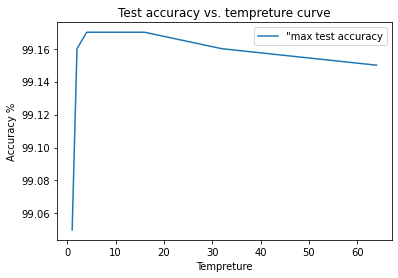

<Figure size 432x288 with 0 Axes>

In [ ]:
# your code start from here for step 6
DISTILLATION_TEMPERATURE_LIST = [1, 2, 4, 16, 32, 64]
max_acc = []
ALPHA = 0.5
train_and_evaluate(cnn_model, compute_teacher_loss)

for t in DISTILLATION_TEMPERATURE_LIST:
    DISTILLATION_TEMPERATURE = t
    fc_model.reset_metrics()
    max_acc.append(train_and_evaluate(fc_model, compute_student_loss))

plt.title("Test accuracy vs. tempreture curve")
plt.plot(DISTILLATION_TEMPERATURE_LIST,max_acc, label='"max test accuracy')
plt.xlabel('Tempreture')
plt.ylabel('Accuracy %')
plt.legend()
plt.savefig("Test_accuracy_vs_t.png")
plt.show()
plt.clf()

# Train student from scratch

In [ ]:
# Build fully connected student.
fc_model_no_distillation = tf.keras.Sequential()

# your code start from here for step 7
fc_model_no_distillation.add(tf.keras.layers.Flatten(input_shape=( 28, 28,1)))
fc_model_no_distillation.add(tf.keras.layers.Dense(748, activation="relu"))
fc_model_no_distillation.add(tf.keras.layers.Dense(748, activation="relu"))
fc_model_no_distillation.add(tf.keras.layers.Dense(NUM_CLASSES))


#@ test {"output": "ignore"}

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = fc_model_no_distillation(images, training=True)
  cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=student_subclass_logits))
  
  return cross_entropy_loss


train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)

Epoch 1: Class_accuracy: 96.74%
Epoch 2: Class_accuracy: 97.71%
Epoch 3: Class_accuracy: 97.63%
Epoch 4: Class_accuracy: 98.10%
Epoch 5: Class_accuracy: 98.04%
Epoch 6: Class_accuracy: 97.78%
Epoch 7: Class_accuracy: 98.37%
Epoch 8: Class_accuracy: 98.11%
Epoch 9: Class_accuracy: 97.91%
Epoch 10: Class_accuracy: 98.19%
Epoch 11: Class_accuracy: 98.30%
Epoch 12: Class_accuracy: 98.16%


<tf.Tensor: shape=(), dtype=float32, numpy=98.369995>

# Comparing the teacher and student model (number of of parameters and FLOPs) 

In [ ]:
# your code start from here for step 8

student_flops = get_flops(fc_model, batch_size=1)
teacher_flops = get_flops(cnn_model, batch_size=1)
print(f"teacher FLOPS: {teacher_flops / 10 ** 9:.03} G")
print(f"student FLOPS: {student_flops / 10 ** 9:.03} G")
def parameter_count(model):
  trainableParams = numpy.sum([numpy.prod(v.get_shape()) for v in model.trainable_weights])
  nonTrainableParams = numpy.sum([numpy.prod(v.get_shape()) for v in model.non_trainable_weights])
  totalParams = trainableParams + nonTrainableParams
  return totalParams

print("teacher parameters:", parameter_count(cnn_model))
print("student parameters:", parameter_count(fc_model))


teacher FLOPS: 0.022 G
student FLOPS: 0.00231 G
teacher parameters: 1011466.0
student parameters: 1154922.0


# Implementing the state-of-the-art KD algorithm

In [ ]:
# your code start from here for step 12

# Build CNN TA.
ta_cnn_model = tf.keras.Sequential()

ta_cnn_model.add(tf.keras.layers.Conv2D(32, (3,3), strides=1, activation="relu",input_shape=(28, 28,1)))
ta_cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=1))
ta_cnn_model.add(tf.keras.layers.Flatten())
ta_cnn_model.add(tf.keras.layers.Dropout(0.5))
ta_cnn_model.add(tf.keras.layers.Dense(256, activation="relu"))
ta_cnn_model.add(tf.keras.layers.Dropout(0.5))
ta_cnn_model.add(tf.keras.layers.Dense(NUM_CLASSES))


# Build CNN teacher.
cnn_model = tf.keras.Sequential()

cnn_model.add(tf.keras.layers.Conv2D(32, (3,3), strides=1, activation="relu",input_shape=(28, 28,1)))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=1))
cnn_model.add(tf.keras.layers.Conv2D(64, (3,3), strides=1, activation="relu"))
cnn_model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=2))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dropout(0.5))
cnn_model.add(tf.keras.layers.Dense(128, activation="relu"))
cnn_model.add(tf.keras.layers.Dropout(0.5))
cnn_model.add(tf.keras.layers.Dense(NUM_CLASSES))


# Build fully connected student.

fc_model = tf.keras.Sequential()
fc_model.add(tf.keras.layers.Flatten(input_shape=( 28, 28,1)))
fc_model.add(tf.keras.layers.Dense(748, activation="relu"))
fc_model.add(tf.keras.layers.Dense(748, activation="relu"))
fc_model.add(tf.keras.layers.Dense(NUM_CLASSES))

ALPHA = 0.7 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
  soft_targets = tf.exp(teacher_logits/temperature) / tf.reduce_sum(tf.exp(teacher_logits/temperature), -1, keepdims=True)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2
@tf.function
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = cnn_model(images, training=True)

  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3
  cross_entropy_loss_value=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=subclass_logits))
  #cee = tf.keras.losses.CategoricalCrossentropy()
  #cross_entropy_loss_value = cee(labels, subclass_logits).numpy()


  return cross_entropy_loss_value
  
def compute_ta_loss_from_teacher(images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  ta_subclass_logits = ta_cnn_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.


  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value =distillation_loss(teacher_subclass_logits,ta_subclass_logits,DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.



  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=ta_subclass_logits))

  return ALPHA*distillation_loss_value+(1-ALPHA)*cross_entropy_loss_value

def compute_student_loss_from_ta(images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.


  ta_subclass_logits = ta_cnn_model(images, training=False)
  distillation_loss_value =distillation_loss(ta_subclass_logits,student_subclass_logits,DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=student_subclass_logits))

  return ALPHA*distillation_loss_value+(1-ALPHA)*cross_entropy_loss_value


train_and_evaluate(cnn_model, compute_teacher_loss)
train_and_evaluate(ta_cnn_model, compute_ta_loss_from_teacher)
train_and_evaluate(fc_model, compute_student_loss_from_ta)


Epoch 1: Class_accuracy: 97.79%
Epoch 2: Class_accuracy: 98.51%
Epoch 3: Class_accuracy: 98.94%
Epoch 4: Class_accuracy: 98.83%
Epoch 5: Class_accuracy: 98.90%
Epoch 6: Class_accuracy: 98.96%
Epoch 7: Class_accuracy: 99.10%
Epoch 8: Class_accuracy: 99.22%
Epoch 9: Class_accuracy: 99.21%
Epoch 10: Class_accuracy: 99.21%
Epoch 11: Class_accuracy: 99.25%
Epoch 12: Class_accuracy: 99.24%
Epoch 1: Class_accuracy: 97.51%
Epoch 2: Class_accuracy: 98.26%
Epoch 3: Class_accuracy: 98.39%
Epoch 4: Class_accuracy: 98.54%
Epoch 5: Class_accuracy: 98.65%
Epoch 6: Class_accuracy: 98.76%
Epoch 7: Class_accuracy: 98.69%
Epoch 8: Class_accuracy: 98.68%
Epoch 9: Class_accuracy: 98.76%
Epoch 10: Class_accuracy: 98.79%
Epoch 11: Class_accuracy: 98.86%
Epoch 12: Class_accuracy: 98.84%
Epoch 1: Class_accuracy: 96.52%
Epoch 2: Class_accuracy: 97.83%
Epoch 3: Class_accuracy: 98.11%
Epoch 4: Class_accuracy: 98.34%
Epoch 5: Class_accuracy: 98.37%
Epoch 6: Class_accuracy: 98.53%
Epoch 7: Class_accuracy: 98.49%
Ep

<tf.Tensor: shape=(), dtype=float32, numpy=98.68>

# (Optional) XAI method to explain models

In [ ]:
# your code start from here for step 13
